# Machine learning customer segmentation project
In this project, I will build a machine learning model for customer segmentation. It involves unsupervised learning, using an unlabeled training set for clustering. I intend to perform clustering to summarize customer segments of a retail store, identifying an ideal client group and building a loyalty program.

I will use the following pipeline, based on CRISP-DM framework:

1. Define the business problem.
2. Initial data understanding.
3. Exploratory data analysis and feature engineering.
4. Data cleaning and preprocessing.
5. Group customers into clusters, modelling.
6. Interpret the results, analysing the groups created (profiling). 
7. Provide marketing suggestions and the loyalty program.
8. Estimate financial results.

In this notebook, I will be covering steps 4 to 8 of the pipeline above. The main objective here is to segment our customers, studying the embedding space, applying techniques such as dimensionality reduction and comparing and evaluating different clustering algorithms in order to make the best segmentation. Moreover, profiles will be created and a loyalty program will be designed, such that concrete financial results will be calculated at the end.

### Importing the libraries

In [75]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Utils.
from scripts.modelling_utils import *

### Reading the data

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 2240 rows and 29 columns.


### Feature engineering
Obtaining the final dataset for clustering, applying all the feature engineering and data cleaning at once.

In [5]:
clustering_df = feature_engineering(df)

In [6]:
clustering_df.columns

Index(['education', 'marital_status', 'income', 'recency', 'mntwines',
       'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'total_accepted_cmp', 'children', 'age', 'relationship_duration',
       'frequency', 'monetary', 'avg_purchase_value'],
      dtype='object')

In [7]:
print(f'The clustering dataset has {clustering_df.shape[0]} rows and {clustering_df.shape[1]} columns.')

The clustering dataset has 2228 rows and 22 columns.


# 4. Data cleaning and preprocessing
- In order to fit machine learning algorithms, there are some transformations we need to apply to the data
- Outliers: I have already treated the outliers, removing those representing inconsistent information.
- Missing values: I will replace the missing values in income column using KNNImputer, in order to avoid biased clustering results. It will take the mean income from the nearest n_neighbors for imputing.
- Numerical features: Some clustering algorithms are sensitive to feature scaling because they use distance calculations such as euclidean distance for training and predicting. Thus, I will apply StandardScaler to numeric attributes.
- Categorical features: I intend to apply OrdinalEncoder to the categorical features because education has an ordinal relationship and marital status has only two categories, which will be encoded as 0 and 1. Moreover, I will scale these features after encoding because some clustering algorithms are sensitive to it, due to distance calculations.

Checking missing values.

In [8]:
clustering_df.isna().sum()

education                 0
marital_status            0
income                   23
recency                   0
mntwines                  0
mntfruits                 0
mntmeatproducts           0
mntfishproducts           0
mntsweetproducts          0
mntgoldprods              0
numdealspurchases         0
numwebpurchases           0
numcatalogpurchases       0
numstorepurchases         0
numwebvisitsmonth         0
total_accepted_cmp        0
children                  0
age                       0
relationship_duration     0
frequency                 0
monetary                  0
avg_purchase_value        2
dtype: int64

I will build the preprocessor below, following the techniques mentioned above.

In [9]:
numerical_features = clustering_df.select_dtypes('number').columns.to_list()
categorical_features = clustering_df.select_dtypes('object').columns.to_list()

print(f'There are {len(numerical_features)} numerical features. They are: ')
print(numerical_features)
print(f'There are {len(categorical_features)} categorical features. They are: ')
print(categorical_features)

There are 20 numerical features. They are: 
['income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth', 'total_accepted_cmp', 'children', 'age', 'relationship_duration', 'frequency', 'monetary', 'avg_purchase_value']
There are 2 categorical features. They are: 
['education', 'marital_status']


In [10]:
num_pipeline = Pipeline(steps=[
    ('knn_imputer', KNNImputer()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder()),
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ]
)

Fitting the preprocessor and converting to DataFrame in order to perform embedding space study.

In [11]:
prepared_df = pd.DataFrame(preprocessor.fit_transform(clustering_df))

In [12]:
prepared_df.columns = clustering_df.columns

In [13]:
prepared_df.head()

,education,marital_status,income,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,...,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,total_accepted_cmp,children,age,relationship_duration,frequency,monetary,avg_purchase_value
0,0.317619,0.307307,0.979727,1.550286,1.755827,2.456149,1.471551,0.842345,0.358429,1.405182,...,0.689529,-0.439298,-1.267017,1.015275,1.501310,1.039875,1.684878,1.129377,-0.892864,1.345208
1,-0.253280,-0.383626,-0.873488,-0.637803,-0.730377,-0.651835,-0.633150,-0.731880,-0.169383,-1.118159,...,-0.139543,-0.439298,1.393599,1.271558,-1.420017,-1.091331,-0.962467,-0.983387,-0.892864,1.345208
2,0.969888,-0.798186,0.359019,0.569418,-0.173283,1.340931,-0.149310,-0.040757,-0.697195,1.405182,...,-0.554079,-0.439298,-1.267017,0.331856,0.040647,0.810670,0.284616,0.155932,-0.892864,-0.743380
3,-1.206779,-0.798186,-0.873488,-0.562352,-0.665920,-0.505577,-0.584766,-0.751077,-0.169383,-0.757682,...,0.274993,-0.439298,0.063291,-1.291266,-1.420017,-0.796447,-0.919177,-0.908784,-0.892864,-0.743380
4,0.325122,1.550987,-0.392365,0.418516,-0.214720,0.152585,-0.004159,-0.559099,1.414053,0.323750,...,-0.139543,-0.439298,0.063291,-1.034984,-1.420017,0.825414,-0.304793,-0.361616,0.572012,-0.743380


### Dimensionality reduction (PCA)
I will apply PCA, a dimensionality reduction technique, for some reasons:

-  PCA can remove noise and irrelevant information from the data, making it easier for clustering algorithms to identify meaningful patterns and clusters within the data.
- By capturing the most significant variations in the data, PCA can enhance the separation between clusters, leading to more accurate and interpretable clustering results.

Fitting PCA to the data.

In [19]:
pca = PCA()
pca.fit(prepared_df)

PCA()

Assessing each principal component's explained variance ratio.

In [20]:
pca.explained_variance_ratio_

array([3.99028866e-01, 9.56073177e-02, 5.75522669e-02, 5.38614381e-02,
       4.72305913e-02, 4.54197133e-02, 4.43978377e-02, 3.98015833e-02,
       3.17694535e-02, 3.08282040e-02, 2.64619373e-02, 2.21245493e-02,
       2.07573205e-02, 1.97431455e-02, 1.75507296e-02, 1.61132287e-02,
       1.25835658e-02, 1.07323851e-02, 6.42432297e-03, 1.89158031e-03,
       1.19963563e-04, 5.34925993e-33])

Obtaining a cumulative sum of the explained variance ratio.

In [21]:
cum_sum = [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]

Plotting the cumulative sum vs the number of components.

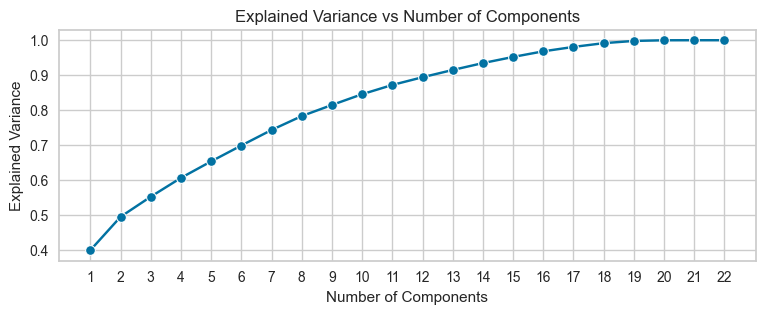

In [97]:
plt.figure(figsize = (9, 3))
sns.lineplot(x = range(1, 23), y = cum_sum, markers = True, marker = 'o')
plt.title('Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks(np.arange(1, 23, 1))
plt.show()

It is possible to observe that the data's variance is fairly well-preserved across the components. Anyway, I tested using different numbers of principal components and I will choose only three for the clustering task because it provided the best segmentation. This choice will lead to better clustering by reducing the impact of noise and dimensionality.

In [84]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(prepared_df)
print(f'The number of components is {pca.n_components_} and the explained variance ratio is {np.sum(pca.explained_variance_ratio_)}')

The number of components is 3 and the explained variance ratio is 0.5521832463313562


### Clustering
I intend to compare different clustering algorithms, selecting one for customer segmentation. The algorithms I chose for comparison are K-Means, Hierarchical Clustering and Gaussian Mixtures Model. To evaluate each one of them and select an optimal k value, I will look at silhouette score.

The silhouette score is a metric used to evaluate the quality of clusters formed by a clustering algorithm. It measures how similar each data point in one cluster is to the other points within the same cluster (a) compared to the most similar neighboring cluster (b). The formula for the silhouette score is as follows:

Silhouette Score (s) = (b - a) / max(a, b)

Where:

'a' is the mean distance between a data point and all other data points in the same cluster.
'b' is the mean distance between a data point and all data points in the nearest cluster (i.e., the cluster that the data point is not a part of).
The silhouette score ranges from -1 to +1, with higher values indicating better-defined and well-separated clusters.

Silhouette scores for different numbers of K-Means clusters.

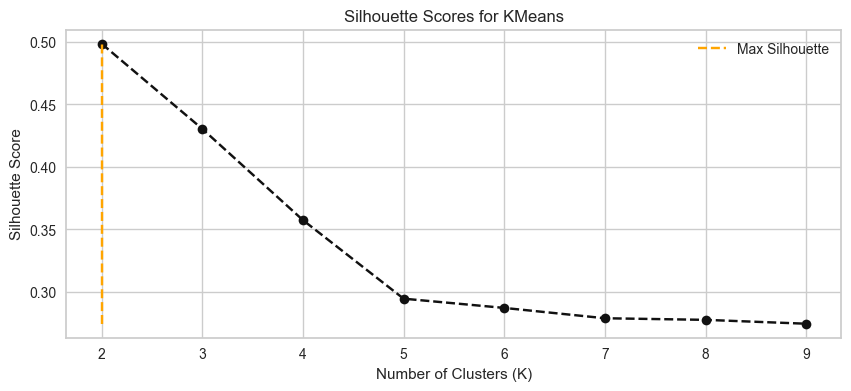

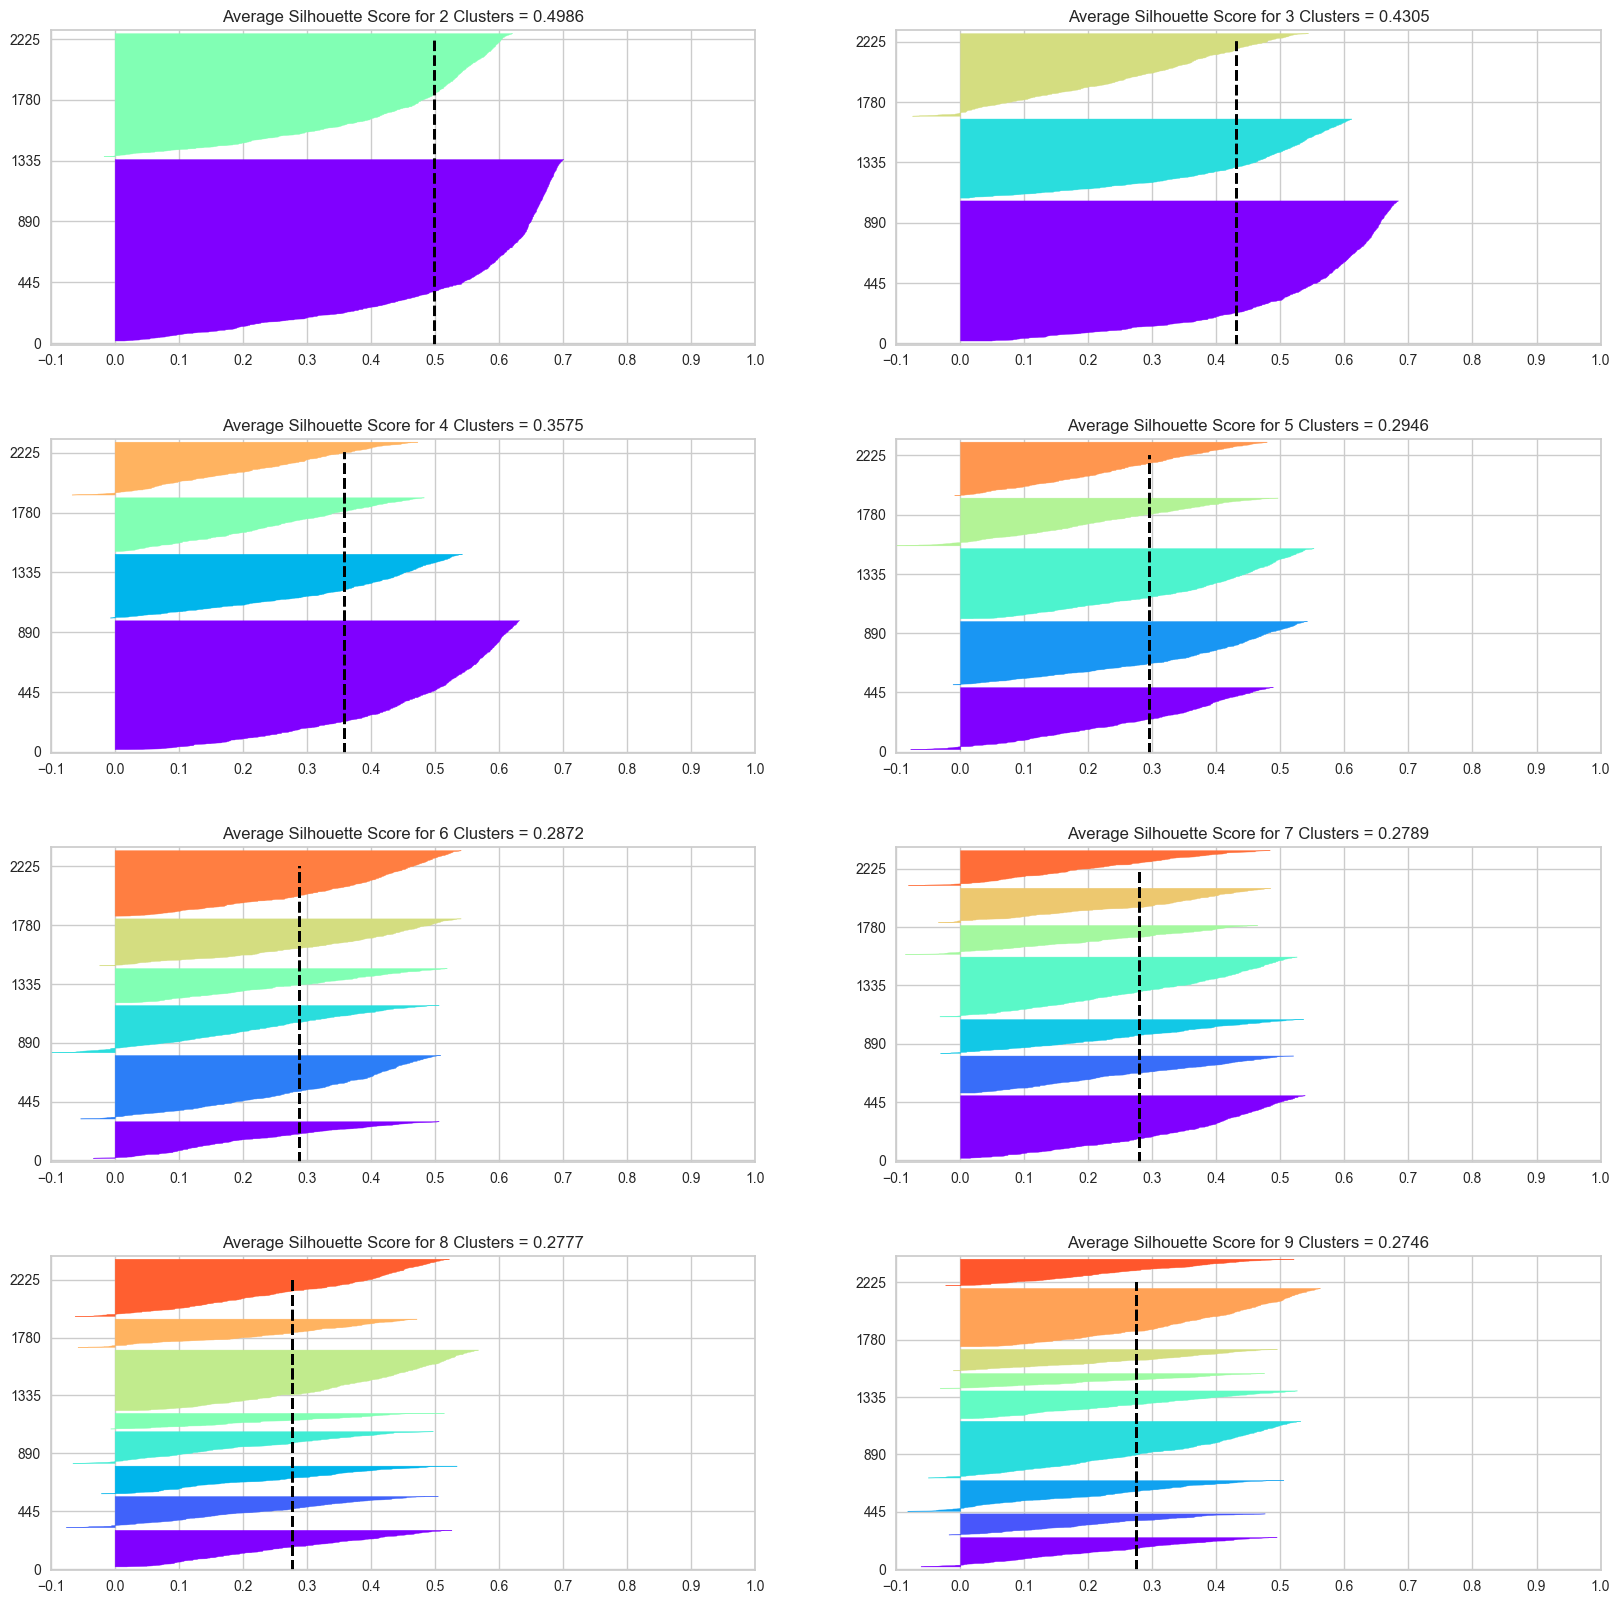

In [96]:
silhouette_analysis(data=df_pca, model=KMeans())

Silhouette scores for different numbers of GaussianMixture clusters.

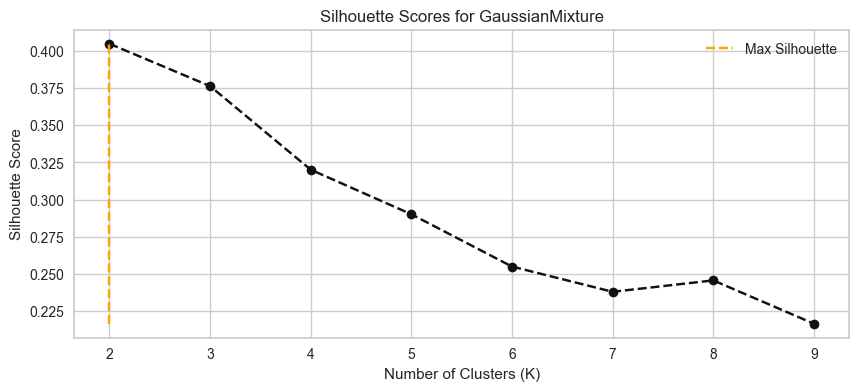

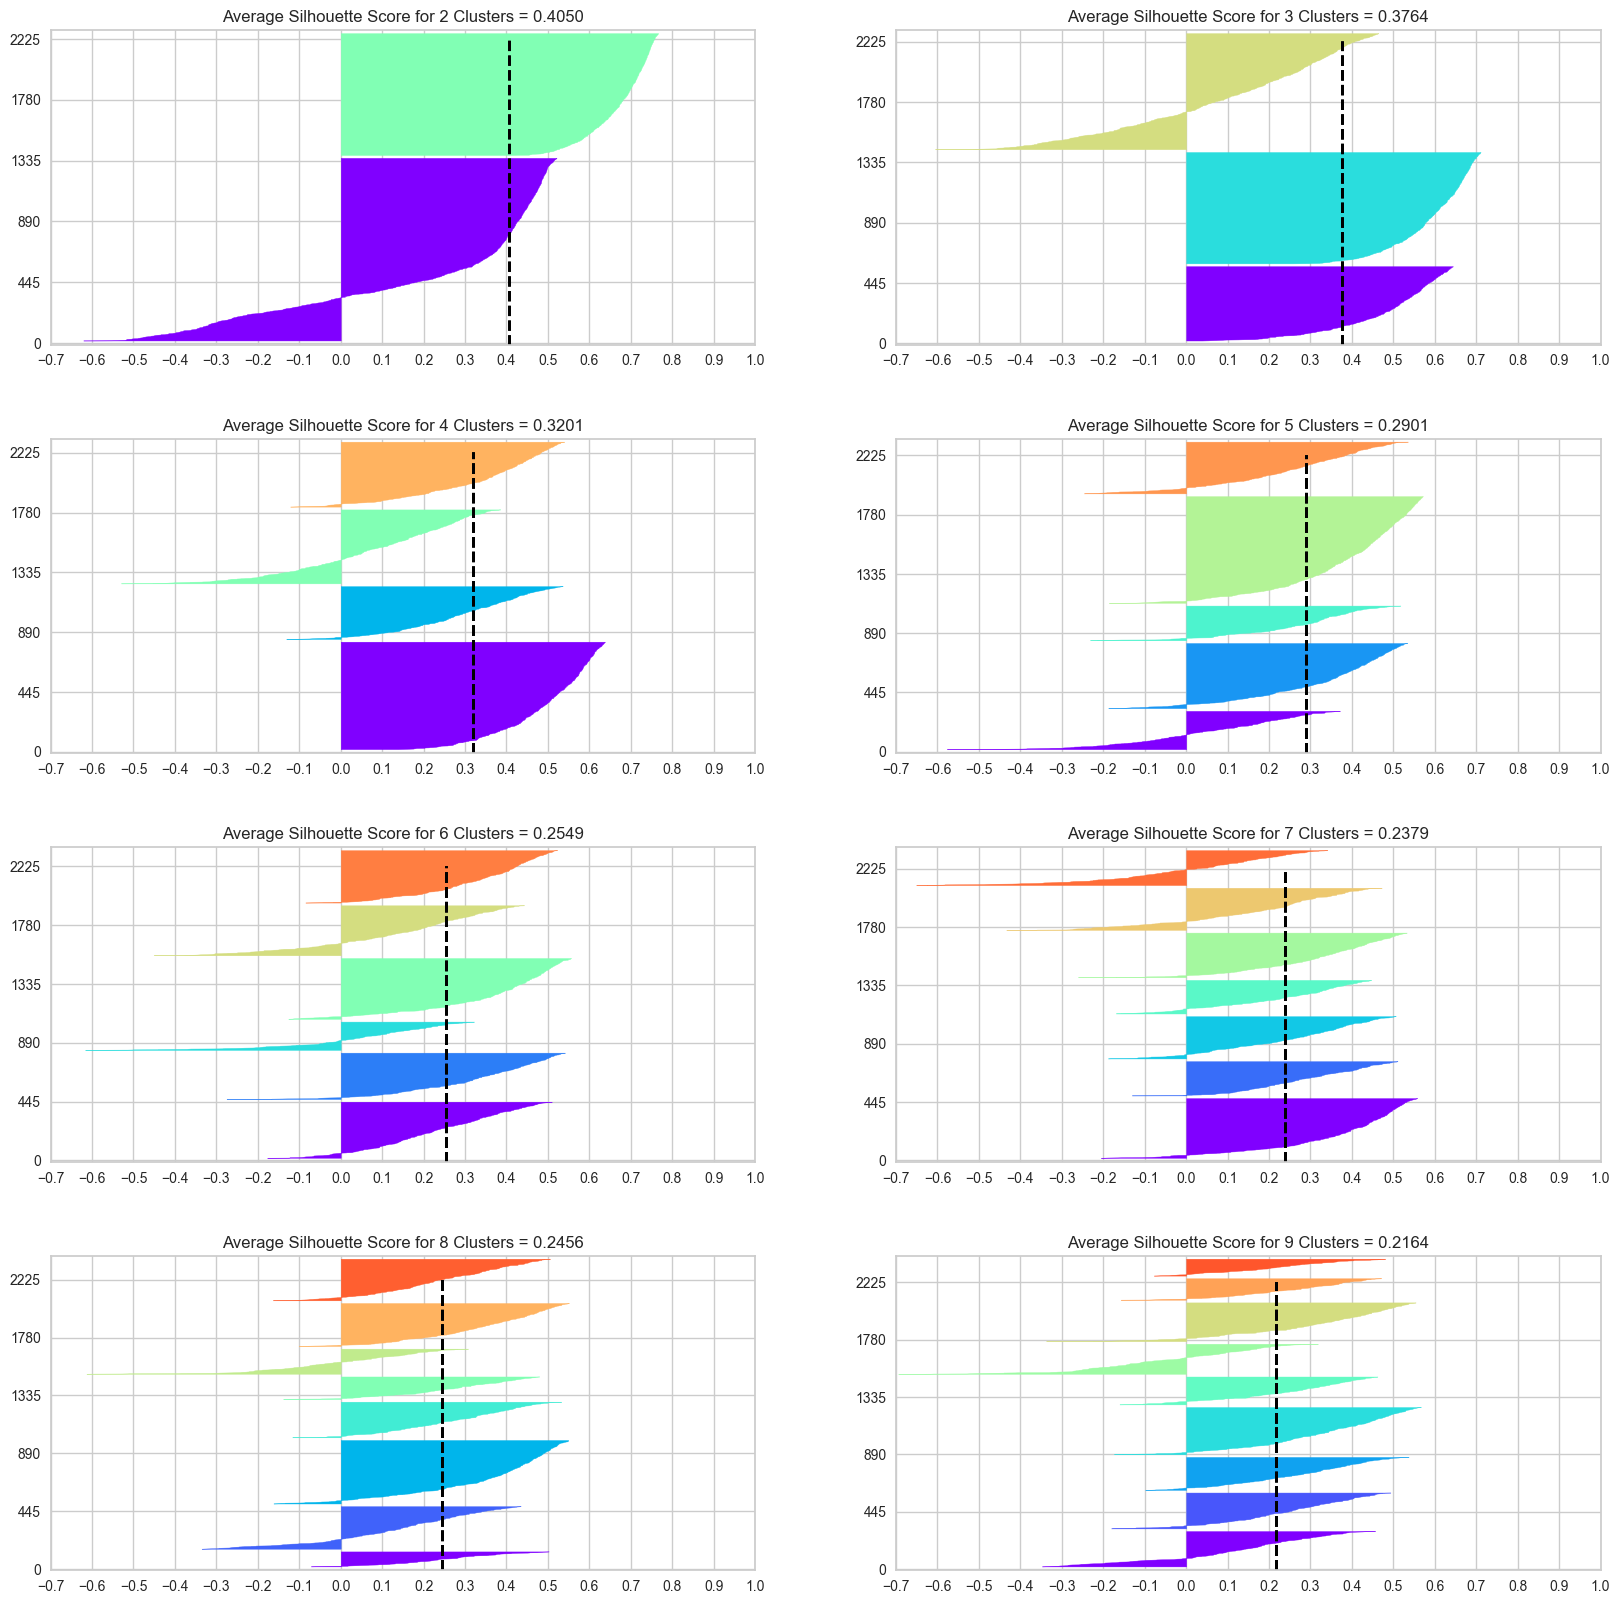

In [95]:
silhouette_analysis(data=df_pca, model=GaussianMixture())

Silhouette scores for different numbers of Hierarchical Clustering clusters.

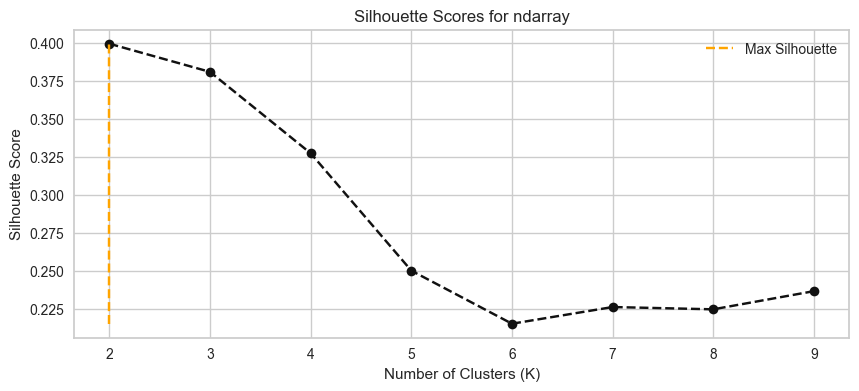

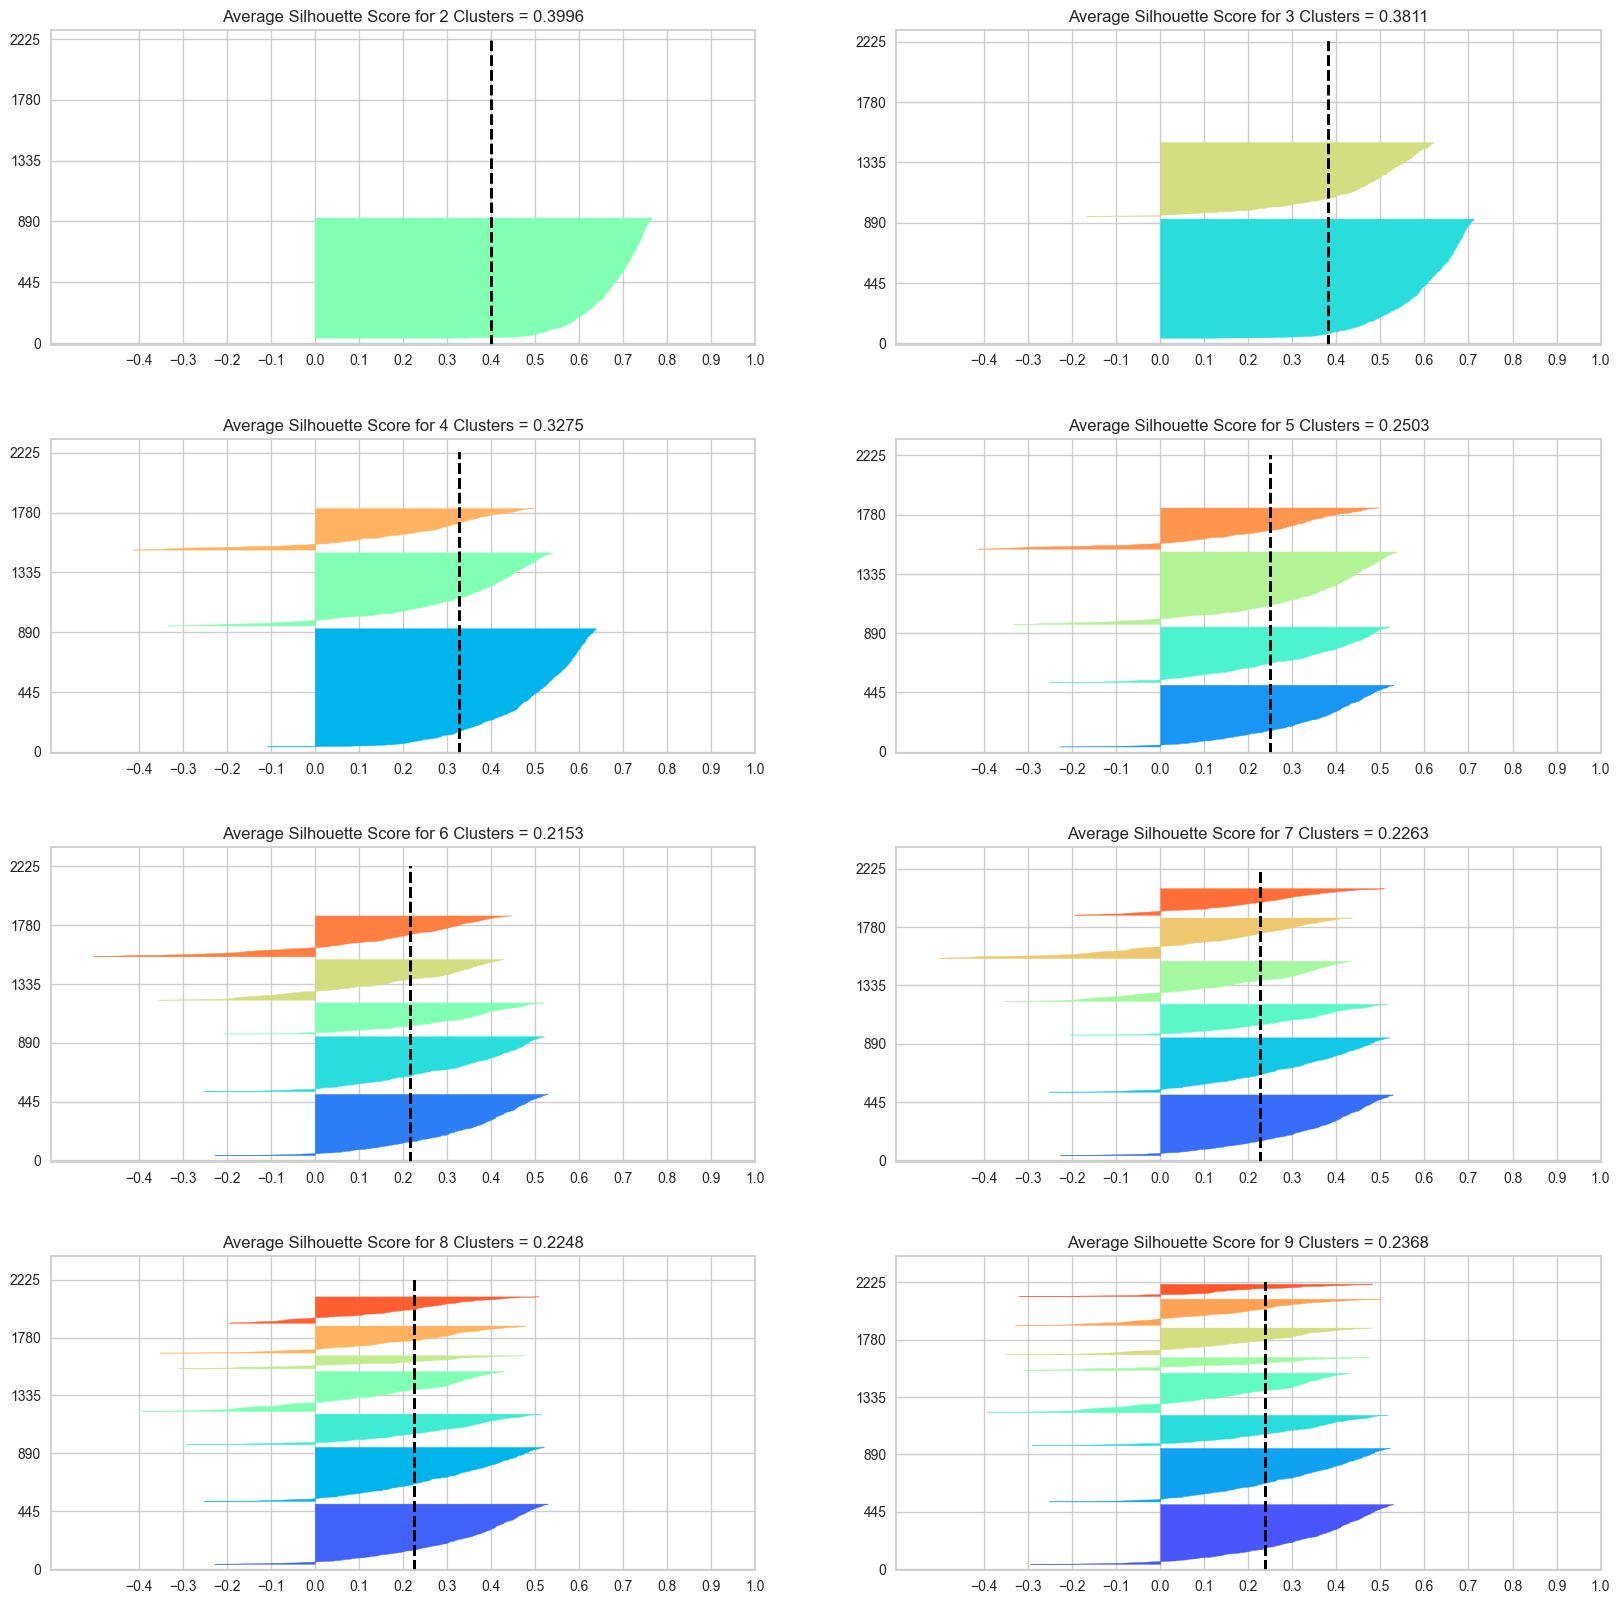

In [94]:
silhouette_analysis(data=df_pca, model=linkage(df_pca))

Clearly, K-Means was the best choice. Therefore, I will select it for the final model training and customer segmentation. Furthermore, the silhouette plot indicates that with k=5, most of the instances extend beyond the dashed line to the right, and the clusters have similar sizes. Thus, I will train K-Means with five clusters.